# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Важны будут следующие хзарактеристрики:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import pandas_profiling
import string
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

import lightgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv

C:\Users\klyuchevenko.e\AppData\Local\Temp\ipykernel_9376\3881822724.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Подготовка данных

In [5]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

* названия столбцов приведем к нижнему регистру
* Высокая степень корреляции Года регистрации и Цены. Вероятно этот признак будет иметь самый высокий вес. 
* Есть 4 дубликата - это не большой процент от общих данных, но удалить стоит. 
* Удалим признаки, которые вероятно не будут иметь значения для прогноза Цены: LastSeen, DateCrawled, DateCreated. Столбец с PostalCode может являться территориальным признаком, который внесет определенный вес для моели. Также, его удаление приведет к дополниельным дубликатам - оставим его. 
* пропуски в категориальных переменных заменим на "Unknown" для дополнительной возможности обучения модели на этих данных
* Для работы с моделями Линейной регрессии и Случайным лесом подготовим отдельно кодировку категориальных признаков. CatBoost и LightGBM справятся с этим сами при обозначении соответствующих столбцов. 
* Для всех моделей попробуем подбор гиперпараметров. 
* Проведем, также скалирование признаков 

In [6]:
df.columns = df.columns.str.lower()


In [7]:
df.duplicated().sum()

4

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

In [10]:
df = df.drop(['datecrawled', 'lastseen', 'datecreated', 'numberofpictures'], axis=1)
df.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'registrationmonth', 'fueltype', 'brand', 'repaired',
       'postalcode'],
      dtype='object')

### Предобработка данных

In [11]:
df.isna().sum()

price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
repaired             71154
postalcode               0
dtype: int64

In [12]:
for column in df.select_dtypes(include='object'):
    df[column] = df[column].fillna('Unknown {}'.format(column))

In [13]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,postalcode
0,480,Unknown vehicletype,1993,manual,0,golf,150000,0,petrol,volkswagen,Unknown repaired,70435
1,18300,coupe,2011,manual,190,Unknown model,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknown repaired,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


In [14]:
df.duplicated().sum()

21329

После удаления лишьних столбцов появились дополнительные дубликаты, не дающие информации для модели и перегружающие нн.  

Появились новые дубликаты из-за удаления временных меток - по сути эти дубликаты перегружают модель и не несут информации - Удалим их.


In [15]:
df = df.drop_duplicates()

In [16]:
df.shape

(333036, 12)

In [17]:
num_df = df.select_dtypes(include='number')

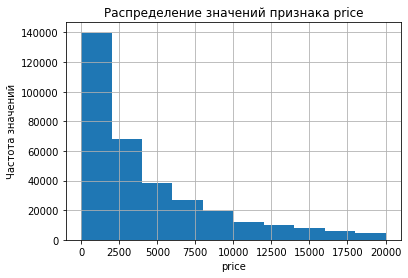

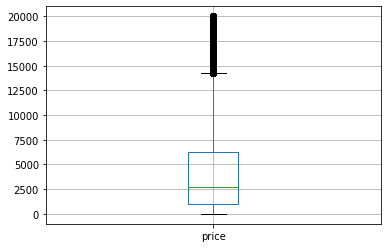

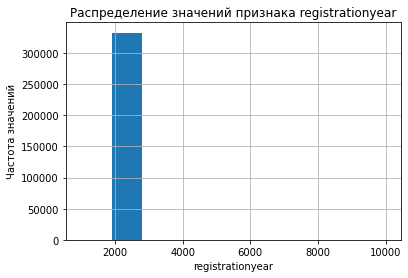

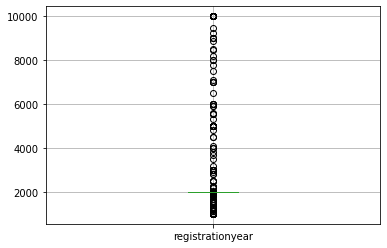

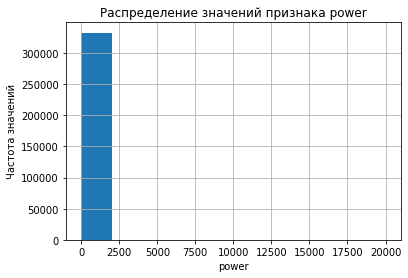

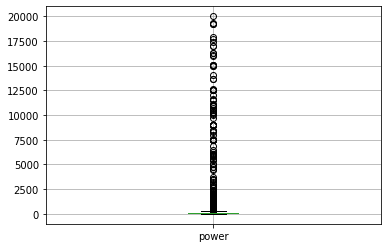

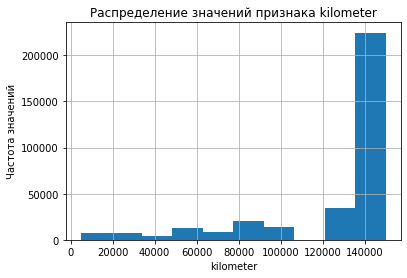

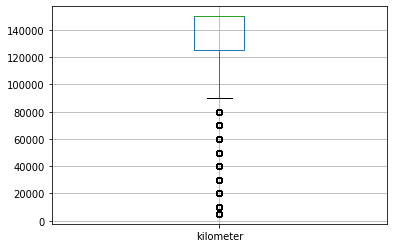

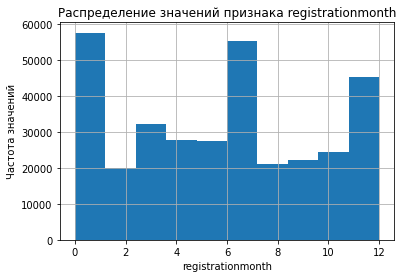

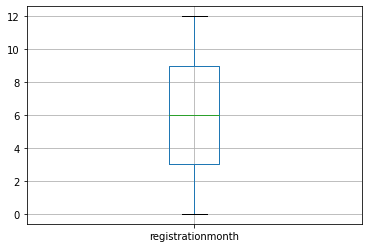

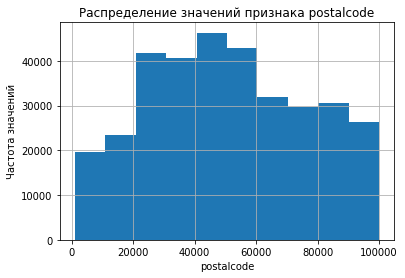

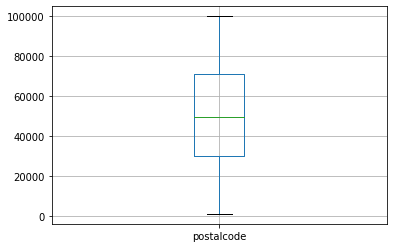

In [19]:
for column in num_df.columns:

    df.hist(column)
    plt.title(f'Распределение значений признака {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Частота значений')
    plt.show()
    
    df.boxplot(column)

* Есть аномалии в значниях года регистрации на максимальных значениях. Даты создания записей ограничены 2016 годом - значит все что больше - аномалии. Для обработки заменим все эти значения нулями и добавим для них дополнительный бинарный признак об отсутствии года регистрации.
* Значения года регистрации ниже 1990 скорее всего ошибка (заполнитли год рождения или иную информацию). Здесь также используем тот же признак 
* Нулевые значения мощности заполним медианой по типу двигателя. 
* На максимальных значениях мощности также есть аномалии. Очевидно, что значения с 1000 до 10000 получены одним лишьним сдвигом запятой, а значения выше 10000 двумя. Также может иметь место использование не корректной систмы исчисления, например кВт вместо л.с. Для нас главное привести к единым порядкам, в данном случае их сократив. 
* В будущем таргете (цене автомобиля) есть существенный обхъем нулевых значений - уберем их

In [18]:
zero_price = df.query('price == 0')
df = df.drop(zero_price.index, axis=0)

In [19]:
df.loc[df['registrationyear'] > 2016, 'no_year'] = 1
df.loc[df['registrationyear'] <= 2016, 'no_year'] = 0
df.loc[df['registrationyear'] > 2016, 'registrationyear'] = 0

In [20]:
df.loc[df['registrationyear'] < 1990, 'registrationyear'].unique()

array([1910,    0, 1981, 1984, 1985, 1989, 1982, 1976, 1983, 1973, 1969,
       1971, 1987, 1986, 1988, 1980, 1970, 1965, 1945, 1925, 1974, 1979,
       1955, 1978, 1972, 1968, 1977, 1961, 1966, 1975, 1963, 1964, 1960,
       1958, 1967, 1959, 1956, 1000, 1941, 1500, 1962, 1929, 1957, 1940,
       1949, 1937, 1951, 1800, 1953, 1954, 1234, 1400, 1950, 1948, 1952,
       1932, 1255, 1942, 1935, 1933, 1936, 1923, 1930, 1001, 1944, 1943,
       1934, 1938, 1928, 1600, 1111, 1039, 1300, 1931, 1602, 1947, 1927,
       1946], dtype=int64)

In [21]:
df.loc[df['registrationyear'] < 1990, 'registrationyear'] = 0
df.loc[df['registrationyear'] < 1990, 'no_year'] = 1


In [24]:
df['no_year'] = df['no_year'].astype('int')

In [26]:
df.loc[df['power'] >= 10000, 'power'] = df.loc[df['power'] >= 10000, 'power'] / 100
df.loc[(df['power'] < 10000) & (df['power'] >= 1000), 'power'] =\
df.loc[(df['power'] < 10000) & (df['power'] >= 1000), 'power'] / 10

Посмотрим сколько нулевых значений мощности в каждом из типов двигателей:

In [27]:
df.loc[(df['power'] == 0), 'vehicletype'].value_counts()

vehicletype
Unknown vehicletype    11948
small                   7502
sedan                   5959
wagon                   4179
bus                     2028
convertible             1045
coupe                    974
suv                      801
other                    563
Name: count, dtype: int64

При этом всего значений по каждому типу

In [28]:
df['vehicletype'].value_counts()

vehicletype
sedan                  83806
small                  73159
wagon                  59512
Unknown vehicletype    32592
bus                    26658
convertible            18598
coupe                  14791
suv                    10912
other                   2995
Name: count, dtype: int64

в каждом из типов есть ненулевые хначения - значит медиану можно вычислить для каждого типа

In [29]:
for vehicletype in df['vehicletype'].unique():
    df.loc[(df['vehicletype'] == vehicletype) & (df['power'] == 0), 'power'] = \
    df.loc[(df['vehicletype'] == vehicletype) & (df['power'] != 0), 'power'].median()

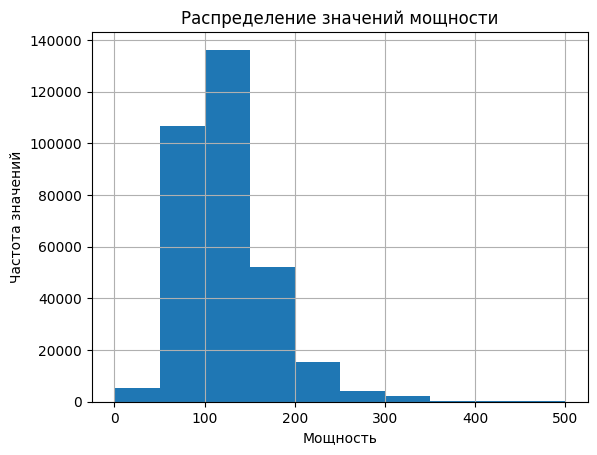

In [30]:
plt.title('Распределение значений мощности')
plt.xlabel('Мощность')
plt.ylabel('Частота значений')
df['power'].hist(range=(0,500))
plt.show()


По итогам предобработки: были заполнены нулевые значения мощности медианным значением соответствующим каждому типу двигателя; заолнены нулевыми значения выдающиеся значения года регистрации и создан соответствующий дополнительный признак об отсутствии года регистрации.

### Подготовка и кодирование данных

Выделим признаки и таргет

In [31]:
features = df.drop(['price'], axis=1) 
target = df['price']

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.3, random_state=12345)

Определим кодировщики 

In [32]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

code_data = features_train.select_dtypes(include='object')
num_data = features_train.select_dtypes(include='number')

scaled_num_data = scaler.fit(num_data)
ohe_code_data = ohe.fit(code_data)
ordinal_code_data = ordinal.fit(code_data)

Создадим функцию модиыикации для кодирования и скалирования признаков:

In [33]:
def modificate(data, method=None, scaler=False):
    
    code_data = data.select_dtypes(include='object')
    num_data = data.select_dtypes(include='number')
    
    if scaler == True:
        num_data = scaled_num_data.transform(num_data)
    
    if method == 'ohe':
        code_data = ohe_code_data.transform(code_data).toarray()
    elif method == 'ordinal':
        code_data = ordinal_code_data.transform(code_data)   
        
    
    return np.concatenate((num_data, code_data), axis=1)

Функция grid_hyp будет подбирать гиперпараметри для случайного леса

## Обучение моделей

### Случайный лес

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> *намеренно использовал малое количество переборов чтобы не перегружать. Так как эта модель показала себя хуже всех в предидущей итерации
</div>

In [34]:
def grid_hyp(data, model=None):
    
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 2)]
    
    grid = {
        'n_estimators': n_estimators,
    }  
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions = grid,
        n_iter=1, cv=2, verbose=1, random_state=35, n_jobs = -1,
        scoring='neg_root_mean_squared_error'
        
    )
    
    search.fit(data, target_train)
    final_model = search.best_estimator_

    print (
        'Лучшие параметры:', search.best_params_,'\n',
        'RMSE', search.best_score_,'\n'
    )  
        
    return final_model

In [35]:
%%time
grid_hyp(
    modificate(features_train, method='ohe', scaler=False),
    model=RandomForestRegressor(random_state = 123456)
)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

Время отработки достаточно высокое, принимая во внимание что у нас всего 2 суммарных итеррации. При этом RMSE нас устраивает. Подбор гиперпараметров в более широком спектре приводит к увеличению времени до 2 часов (20 итераций), то есть время растет экспаненциально. Попробуем улучшить результат RMSE включив скалирование не увеличивая количество итераций перебора

In [35]:
%%time
grid_hyp(modificate(features_train, method='ohe', scaler=True),
    model=RandomForestRegressor(random_state = 123456)
)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

Результат по RMSE не улчшился, время на том же уровне. Попробуем сократить время обучения сокращения колчичество признаков за счет ordinal coding, который не будет создават дополнителные столбцы

In [36]:
%%time
final_model = grid_hyp(modificate(features_train, method='ordinal', scaler=True),
    model=RandomForestRegressor(random_state = 123456)
)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

Скорость увеличилась значительно! Обучение заняло всего 6 минут. Однако метрика RMSE ухудшилась. Посмотрим время обучение и предикст самой быстрой модели на ordinal 

In [37]:
%%time
final_model.fit(modificate(features_train, method='ordinal', scaler=True), target_train)

NameError: name 'final_model' is not defined

In [38]:
%%time
final_model.predict(modificate(features_train, method='ordinal', scaler=True))

NameError: name 'final_model' is not defined

### LGBM

In [39]:
for feature in features_train.select_dtypes(include='object').columns:
    features_train[feature] = pd.Series(features_train[feature], dtype="category")

/tmp/ipykernel_92/902905881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[feature] = pd.Series(features_train[feature], dtype="category")


In [40]:
features_train.dtypes

vehicletype          category
registrationyear        int64
gearbox              category
power                 float64
model                category
kilometer               int64
registrationmonth       int64
fueltype             category
brand                category
repaired             category
postalcode              int64
no_year                 int64
dtype: object

In [41]:
%%time

model = LGBMRegressor()
kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(
    model,
    features_train,
    target_train,
    scoring='neg_root_mean_squared_error',
    cv=kf, n_jobs=-1, error_score='raise'
)

print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

KeyboardInterrupt: 

RMSE улучшили больше чем на 100 пунктов но за три минуты с учетом десяти кроссвалидаций - Есть пространство для подбора параметров:

In [42]:
def gbm_hyp(data, model=None):

    objective = ['Regression_l1', 'Regression']
    num_leaves = [int(x) for x in np.linspace(start = 10, stop = 100, num = 20)]
    
    grid = {
        'objective': objective,
        'num_leaves': num_leaves,
    }  
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions = grid,
        n_iter=25, cv=4, verbose=0, random_state=35, n_jobs = -1,
        scoring='neg_root_mean_squared_error',
        
    )
    
    search.fit(data, target_train)
    final_model = search.best_estimator_

    print (
        'Лучшие параметры:', search.best_params_,'\n',
        'RMSE', search.best_score_,'\n'
    )  
        
    return final_model

In [43]:
%%time
gbm_best = gbm_hyp(features_train, model=LGBMRegressor(random_state=35))

KeyboardInterrupt: 

In [44]:
%%time
gbm_best.fit(features_train, target_train)

NameError: name 'gbm_best' is not defined

In [45]:
%%time
gbm_best.predict(features_train)

NameError: name 'gbm_best' is not defined

Удалось достичь лучших показателей в 1737 для RMSE за рекордные 6 минут.

### CatBoost

In [46]:
params = {"iterations": 100,
          "depth": 15,
          "loss_function": "RMSE",
          "verbose": False
         }
cv_dataset = Pool(data=features_train,
                  label=target_train,
                  cat_features=list(features_train.select_dtypes(include='category').columns)
                 )
scores = cv(cv_dataset,
            params,      
            fold_count=3, 
            plot="True"
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]


KeyboardInterrupt: 

In [ ]:
def cat_hyp(data, model=None):

    iterations = [int(x) for x in np.linspace(start = 50, stop = 150, num = 6)]
    depth = [int(x) for x in np.linspace(start = 5, stop = 16, num = 5)]
    
    grid = {
        'iterations': iterations,
        'depth': depth
    }  
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions = grid,
        n_iter=10, cv=3, verbose=0, random_state=35, n_jobs = -1,
        scoring='neg_root_mean_squared_error',
        
    )
    
    search.fit(data, target_train)
    final_model = search.best_estimator_

    print (
        'Лучшие параметры:', search.best_params_,'\n',
        'RMSE', search.best_score_,'\n'
    )  
        
    return final_model

In [ ]:
best_cat = cat_hyp(
    features_train,
    model=CatBoostRegressor(
        cat_features=list(features_train.select_dtypes(include='category').columns)
    )
)

In [ ]:
%%time
best_cat.fit(features_train, target_train)

In [ ]:
%%time
best_cat.predict(features_train)

Остановимся на LGBM gbm_best с резкльтатом в 1671 для RMSE, которая обучилась также быстрее всех.


| Модель/этап| RMSE | Время (Обучение / Предсказание) |
| --- | --- | --- |
| Случайный Лес(Ordinal) | 1882 | 9.33s / 1.44s |
| LGBM | 1671 | 817ms / 440ms |
| CatBoost | 1716 | 18.9s / 191 ms |

## Анализ моделей

In [ ]:
for feature in features_test.select_dtypes(include='object').columns:
    features_test[feature] = pd.Series(features_test[feature], dtype="category")

In [ ]:
%%time
predict = gbm_best.predict(features_test)
mean_squared_error(target_test, predict, squared=False)

In [ ]:
baseline_model = DummyRegressor(
    strategy='mean'
)
baseline_model.fit(features_train, target_train)

In [ ]:
predict_baseline = baseline_model.predict(features_test)
mean_squared_error(target_test, predict_baseline, squared=False)

Для базовой модели результат значительно хуже

В результате LGBM дал лучший результат на тренировочно датасете как по времени обучения, так и по качеству RMSE. На тестовой выборке подобранная модель LGBM показала почти идентичный результат RMSE в 1671, что ниже граничного 2500. Рекордное время обучение у случайного леса, но перебор гиперпараметров здесь занимает очень много времени. Результаты сведены в таблицу. 